In [1]:
from torch import empty, set_grad_enabled
set_grad_enabled(False) # REQUIRED

## 1. Generating the data

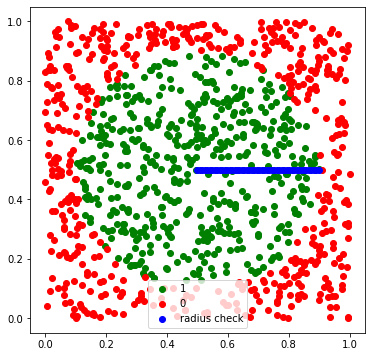

In [2]:
from utils import generate_dataset, show_dataset

X_train, y_train, X_test, y_test = generate_dataset(1000)
show_dataset(X_train, y_train)

### Testing linear regression

Text(0.5, 1.0, 'Error on b')

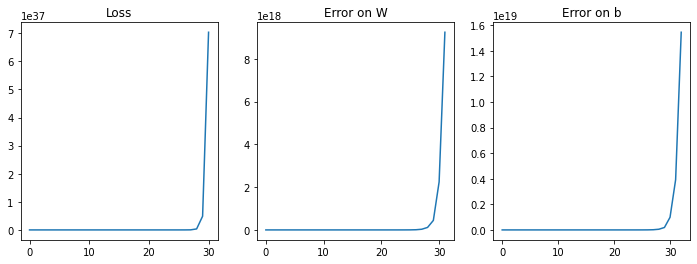

In [3]:
from module import Linear, ReLU, Tanh, LossMSE
import matplotlib.pyplot as plt




n_samples = 1000
input_dim = 20
output_dim = 2

x0 = empty((n_samples, input_dim)).uniform_()


y = empty((n_samples, output_dim)).uniform_()


W = empty((output_dim, input_dim)).normal_(0, 1)
b = empty(output_dim).normal_(0, 1)
y = empty((n_samples, output_dim)).zero_() 


for i in range(n_samples):
    x = x0[i]
    y[i] = W.mv(x) + b
    
y += 0.05*empty(y.shape).normal_(0, 1)
    
ll = Linear(input_dim, output_dim)
LS = LossMSE()


losses, d_w, d_b = [], [], []


nb_epochs = 10000
mini_batch_size = 100
lr = 1e-1/n_samples*mini_batch_size



for epoch in range(nb_epochs):
    ll.zero_grad()
    for i in range(0, x0.size(0), mini_batch_size):
        input_ = x0.narrow(0, i, mini_batch_size)
        target = y.narrow(0, i, mini_batch_size)
        x2 = ll.forward(input_)
        
        loss = LS.forward(x2, target)

        grad_output = LS.backward()
        grad_input = ll.backward(grad_output)
        

        ll.W -= lr*ll.grad_W
        ll.b -= lr*ll.grad_b
        losses.append(loss.item())
        d_w.append((W-ll.W).norm())
        d_b.append((b-ll.b.squeeze()).norm())
    
f, ax = plt.subplots(1, 3, figsize = (12, 4))

ax[0].plot(losses)
ax[0].set_title('Loss')
ax[1].plot(d_w)
ax[1].set_title('Error on W')
ax[2].plot(d_b)
ax[2].set_title('Error on b')

In [4]:
W - ll.W

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])

In [5]:
b - ll.b

tensor([nan, nan])

In [6]:
d_w[-1], d_b[-1]

(tensor(nan), tensor(nan))

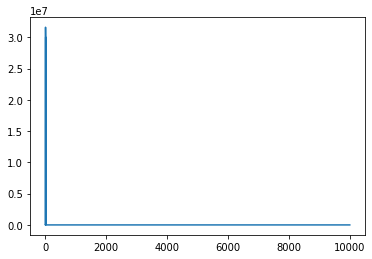

In [7]:
LS = LossMSE()

hidden_dim = 5
L1 = Linear(input_dim, hidden_dim)
R = ReLU()
L2 = Linear(hidden_dim, output_dim)

losses, d_w, d_b = [], [], []


nb_epochs = 1000
mini_batch_size = 100
lr = 1e-1/n_samples*mini_batch_size



for epoch in range(nb_epochs):
    L1.zero_grad()
    L2.zero_grad()
    for i in range(0, x0.size(0), mini_batch_size):
        input_ = x0.narrow(0, i, mini_batch_size)
        target = y.narrow(0, i, mini_batch_size)
        
        # forward pass
        x1 = L1.forward(input_)
        s1 = R.forward(x1)
        x2 = L2.forward(s1)
        loss = LS.forward(x2, target)
        # backward pass
        grad_x2 = LS.backward()
        grad_s1 = L2.backward(grad_x2)
        grad_x1 = R.backward(grad_s1)
        grad_input = L1.backward(grad_x1)
        

        L1.W -= lr*L1.grad_W
        L1.b -= lr*L1.grad_b
        
        L2.W -= lr*L2.grad_W
        L2.b -= lr*L2.grad_b
        
        losses.append(loss.item())
    

plt.plot(losses)


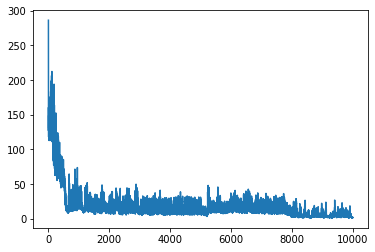

In [8]:
from module import Sequential 


hidden_1, hidden_2 = 6, 3
model = Sequential(Linear(input_dim, hidden_1), 
                   Tanh(),
                   Linear(hidden_1, hidden_2), 
                   Tanh(),
                   Linear(hidden_2, output_dim))


losses, d_w, d_b = [], [], []


nb_epochs = 1000
mini_batch_size = 100
lr = 1e-2/n_samples*mini_batch_size



for epoch in range(nb_epochs):
    model.zero_grad()
    
    for i in range(0, x0.size(0), mini_batch_size):
        input_ = x0.narrow(0, i, mini_batch_size)
        target = y.narrow(0, i, mini_batch_size)
        
        # forward pass
        out = model.forward(input_)
        loss = LS.forward(out, target)
        # backward pass
        grad_output = LS.backward()
        grad_input = model.backward(grad_output)
        
        for layer in model.layers:
            if layer.trainable:
                layer.W -= lr*layer.grad_W
                layer.b -= lr*layer.grad_b
        
        losses.append(loss.item())
    

plt.plot(losses)


### Testing on MNIST

In [9]:
from dlc_practical_prologue import load_data

train_input, train_target, test_input, test_target = load_data(one_hot_labels = True, normalize = True, flatten = True)

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


In [10]:
train_input.shape, train_target.shape

(torch.Size([1000, 784]), torch.Size([1000, 10]))

In [11]:
from math import sqrt

In [12]:
s = 'xavier_relu'
s.startswith('xavier')

True

Epoch 1: loss = 3.810, accuracy = 54.1% (train)/46.1% (test))
Epoch 11: loss = 2.151, accuracy = 85.3% (train)/69.3% (test))
Epoch 21: loss = 1.614, accuracy = 91.9% (train)/76.0% (test))
Epoch 31: loss = 1.334, accuracy = 95.8% (train)/80.5% (test))
Epoch 41: loss = 1.364, accuracy = 98.1% (train)/82.3% (test))
Epoch 51: loss = 1.384, accuracy = 97.8% (train)/82.0% (test))
Epoch 61: loss = 1.194, accuracy = 98.3% (train)/82.6% (test))
Epoch 71: loss = 1.189, accuracy = 98.7% (train)/84.4% (test))
Epoch 81: loss = 1.284, accuracy = 98.8% (train)/83.2% (test))
Epoch 91: loss = 1.170, accuracy = 98.9% (train)/83.6% (test))


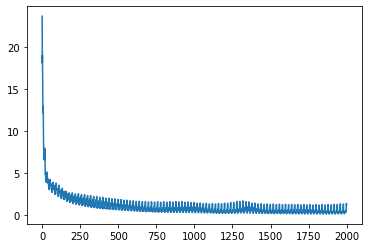

In [13]:
LS = LossMSE()

input_dim, h1, h2, h3, output_dim = 28**2, 100, 50, 20, 10

init = 'xavier'
model = Sequential(Linear(input_dim, h1, init), 
                   Tanh(),
                   Linear(h1, h2, init), 
                   Tanh(),
                   Linear(h2, h3, init),
                   Tanh(),
                   Linear(h3, output_dim, init))


losses, d_w, d_b = [], [], []


nb_epochs = 100
mini_batch_size = 50
lr = 1e-2/n_samples*mini_batch_size



for epoch in range(nb_epochs):
    
    model.zero_grad()
    
    for i in range(0, train_input.size(0), mini_batch_size):
        input_ = train_input.narrow(0, i, mini_batch_size)
        target = train_target.narrow(0, i, mini_batch_size)
        
        # forward pass
        out = model.forward(input_)
        loss = LS.forward(out, target)
        # backward pass
        grad_output = LS.backward()
        grad_input = model.backward(grad_output)
        
        for layer in model.layers:
            if layer.trainable:
                layer.W -= lr*layer.grad_W
                layer.b -= lr*layer.grad_b
        
        losses.append(loss.item())
        
    if epoch %10 == 1:
        prediction_train = model.forward(train_input).argmax(axis = 1)
        target_train = train_target.argmax(axis = 1)
        accuracy_train = (prediction_train == target_train).sum()/len(target_train)
        prediction_test = model.forward(test_input).argmax(axis = 1)
        target_test = test_target.argmax(axis = 1)
        accuracy_test = (prediction_test == target_test).sum()/len(target_test)
        print('Epoch {:d}: loss = {:.3f}, accuracy = {:.1f}% (train)/{:.1f}% (test))'.format(epoch, loss.item(),
                                                                                             accuracy_train*100, 
                                                                                             accuracy_test*100))
    
plt.plot(losses)

In [44]:
import math

def kaiming(m, h):
    return torch.randn(m, h)*math.sqrt(2./m)
def kaiming2(m, h):
    return torch.empty((m, h)).normal_(0, math.sqrt(2./m))
def relu(x):
    return x.clamp_min(0.)

In [46]:
x = torch.randn(1000)

for i in range(1000):
    a = kaiming(1000, 1000)
    x = relu(a @ x)
x.mean(), x.std()

(tensor(0.0527), tensor(0.0753))

In [91]:
x = torch.randn(1000)

mu = x.mean()
std = x.std()

In [87]:
x.mean(), x.std()

(tensor(0.5464), tensor(1.3112))

In [101]:
mu = x.mean()
std = x.std()
x.sub_(mu).div_(std)
x.mean(), x.std()

(tensor(0.), tensor(1.))

In [90]:
x.mean(), x.std()

(tensor(0.), tensor(1.))

In [104]:
n_samples = 10000
X_train, y_train, X_test, y_test = generate_dataset(n_samples)
mean, std = X_train.mean(), X_train.std()
print(mean, std)

tensor(0.4982) tensor(0.2889)


In [105]:
math.sqrt(1/12)

0.28867513459481287